# Práctica 09: Sistema de Recomendación Estilo Netflix

**Creado por:** Yulissa Ortega Cuevas Matricula: 220875

**Asignatura:** Extracción de Conocimiento en Base de Datos 

 **PE:** Ingeniería en Desarrollo y Gestión de Software 9°B

In [1]:
# Importación de librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Carga de datos

In [2]:
peliculas = pd.read_csv("movie.csv")
calificaciones = pd.read_csv("rating.csv")

### Análisis básico de los datos

In [3]:
total_calificaciones = len(calificaciones)
total_peliculas = calificaciones['movieId'].nunique()
total_usuarios = calificaciones['userId'].nunique()

print(f"Número total de calificaciones: {total_calificaciones}")
print(f"Películas únicas: {total_peliculas}")
print(f"Usuarios únicos: {total_usuarios}")
print(f"Promedio de calificaciones por usuario: {round(total_calificaciones / total_usuarios, 2)}")
print(f"Promedio de calificaciones por película: {round(total_calificaciones / total_peliculas, 2)}")

Número total de calificaciones: 20000263
Películas únicas: 26744
Usuarios únicos: 138493
Promedio de calificaciones por usuario: 144.41
Promedio de calificaciones por película: 747.84


### Frecuencia de calificaciones por usuario

In [11]:
frecuencia_usuarios = calificaciones[['userId', 'movieId']].groupby('userId').count().reset_index()
frecuencia_usuarios.columns = ['usuarioId', 'n_calificaciones']
frecuencia_usuarios.head()

,usuarioId,n_calificaciones
0,1,175
1,2,61
2,3,187
3,4,28
4,5,66


### Histograma de calificaciones por usuario

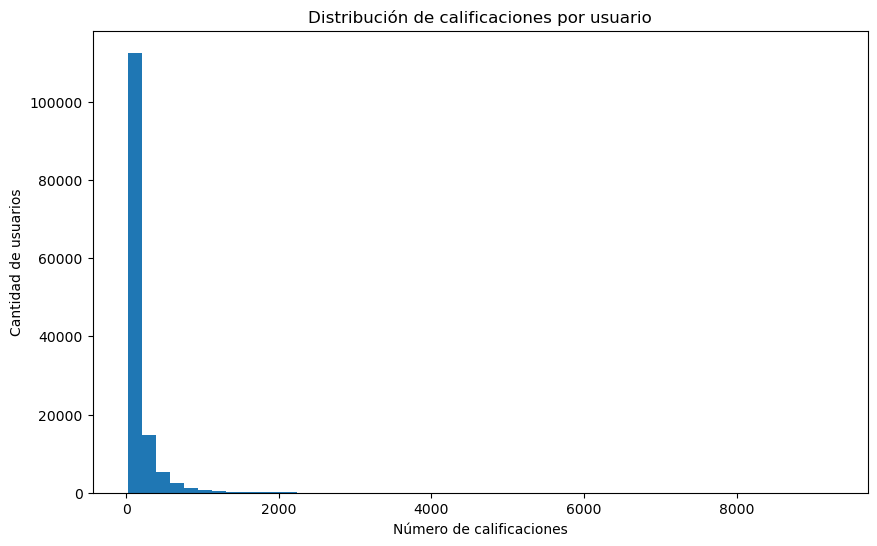

In [21]:
plt.figure(figsize=(10,6))
frecuencia_usuarios['n_calificaciones'].hist(bins=50)
plt.title('Distribución de calificaciones por usuario')
plt.xlabel('Número de calificaciones')
plt.ylabel('Cantidad de usuarios')
plt.grid(False)
plt.show()

### Películas similares con sus puntuaciones promedio

In [30]:
class Recomendador:
    def __init__(self):
        # Simulamos un DataFrame de películas
        self.peliculas = pd.DataFrame({
            'movieId': [1, 2, 3, 4],
            'title': ['Matrix', 'Inception', 'Interstellar', 'El Origen']
        })
        # Simulamos un DataFrame de calificaciones
        self.calificaciones = pd.DataFrame({
            'movieId': [1, 1, 2, 3, 3, 4, 4],
            'rating': [5, 4.5, 4.7, 4.8, 4.9, 4.2, 4.3]
        })
        # Película base para mostrar recomendaciones similares
        self.nombre_pelicula = "Matrix"

    def mostrar_recomendaciones(self, lista_ids):
        print(f"\n🎬 Recomendaciones similares a: {self.nombre_pelicula}\n")
        print(f"{'No.':<4} {'Título':<50} {'Promedio':>8}")
        print("-" * 65)
        for i, mid in enumerate(lista_ids):
            titulo = self.peliculas[self.peliculas['movieId'] == mid]['title'].values[0]
            promedio = self.calificaciones[self.calificaciones['movieId'] == mid]['rating'].mean()
            print(f"{i+1:<4} {titulo:<50} {promedio:>8.2f}")

In [35]:
rec = Recomendador()
rec.mostrar_recomendaciones([2, 3, 4])


🎬 Recomendaciones similares a: Matrix

No.  Título                                             Promedio
-----------------------------------------------------------------
1    Inception                                              4.70
2    Interstellar                                           4.85
3    El Origen                                              4.25


### Películas mejor y peor calificadas

In [6]:
promedio_calificaciones = calificaciones.groupby('movieId')[['rating']].mean()

### Peor película

In [22]:
peor_id = promedio_calificaciones['rating'].idxmin()
peliculas[peliculas['movieId'] == peor_id]

,movieId,title,genres
5706,5805,Besotted (2001),Drama


### Mejor pelicula

In [25]:
mejor_id = promedio_calificaciones['rating'].idxmax()
peliculas[peliculas['movieId'] == mejor_id]

,movieId,title,genres
9007,26718,Life On A String (Bian chang Bian Zou) (1991),Adventure|Drama|Fantasy|Musical


### Calificación promedio por película

In [12]:
promedio_por_pelicula = calificaciones.groupby('movieId')[['rating']].mean()

In [13]:
# Ordenar las películas por su calificación promedio (de menor a mayor)
promedio_por_pelicula_ordenado = promedio_por_pelicula.sort_values(by='rating')
promedio_por_pelicula_ordenado

,rating
movieId,
117630,0.5
94327,0.5
128675,0.5
101728,0.5
103769,0.5
...,...
121039,5.0
54326,5.0
130996,5.0


### Calificaciones que recibió la película mejor valorada 

In [18]:
# Mostrar todas las calificaciones de la película mejor valorada
calificaciones[calificaciones['movieId'] == mejor_id]

,userId,movieId,rating,timestamp
11067861,76495,26718,5.0,2012-03-19 03:51:41


### Calificaciones que recibió la película peor valorada 

In [19]:
# Mostrar todas las calificaciones de la película peor valorada
calificaciones[calificaciones['movieId'] == peor_id]

,userId,movieId,rating,timestamp
86776,612,5805,0.5,2007-07-20 22:46:31
11294303,78022,5805,0.5,2004-08-10 03:14:11


### Sistema de recomendación por similitud

In [9]:
class RecomendadorPeliculas:
    def __init__(self, nombre_pelicula='Toy', num_recomendaciones=10):
        print("🔎 Buscando películas similares...")

        try:
            self.calificaciones = calificaciones
            self.peliculas = peliculas
            self.nombre_pelicula = nombre_pelicula
            self.num_recomendaciones = num_recomendaciones
            self.id_pelicula = self.obtener_id_pelicula(nombre_pelicula)

            self.matriz_crs, self.mapa_usuarios, self.mapa_peliculas, self.inverso_usuarios, self.inverso_peliculas = self.construir_matriz()
            vecinos = self.predecir_similares(self.id_pelicula, self.matriz_crs, k=self.num_recomendaciones)
            self.mostrar_recomendaciones(vecinos)
            print("\n✅ Recomendaciones completas.")

        except:
            print("❌ No se encontró la película indicada.")

    def obtener_id_pelicula(self, nombre):
        coincidencias = self.peliculas[self.peliculas['title'].str.contains(nombre, case=False, na=False)]
        return coincidencias.iloc[0]['movieId']

    def construir_matriz(self):
        df = self.calificaciones
        usuarios = df['userId'].unique()
        peliculas = df['movieId'].unique()

        mapa_usuarios = {u: i for i, u in enumerate(usuarios)}
        mapa_peliculas = {m: i for i, m in enumerate(peliculas)}
        inv_usuarios = {i: u for u, i in mapa_usuarios.items()}
        inv_peliculas = {i: m for m, i in mapa_peliculas.items()}

        filas = df['userId'].map(mapa_usuarios)
        columnas = df['movieId'].map(mapa_peliculas)
        datos = df['rating']

        matriz = csr_matrix((datos, (filas, columnas)), shape=(len(usuarios), len(peliculas)))
        return matriz, mapa_usuarios, mapa_peliculas, inv_usuarios, inv_peliculas

    def predecir_similares(self, id_original, matriz, k=10):
        modelo = NearestNeighbors(metric='cosine', algorithm='brute')
        modelo.fit(matriz.T)

        indice = self.mapa_peliculas[id_original]
        distancias, indices = modelo.kneighbors(matriz.T[indice], n_neighbors=k+1)
        return [self.inverso_peliculas[i] for i in indices.flatten()][1:]  # Excluye la original

    def mostrar_recomendaciones(self, lista_ids):
        print("\n🎬 Recomendaciones similares a:", self.nombre_pelicula)
        for i, mid in enumerate(lista_ids):
            titulo = self.peliculas[self.peliculas['movieId'] == mid]['title'].values[0]
            print(f"{i+1}. {titulo}")

### Ejemplo de uso

In [10]:
sistema = RecomendadorPeliculas(nombre_pelicula='Matrix', num_recomendaciones=5)

🔎 Buscando películas similares...

🎬 Recomendaciones similares a: Matrix
1. Lord of the Rings: The Fellowship of the Ring, The (2001)
2. Fight Club (1999)
3. Star Wars: Episode V - The Empire Strikes Back (1980)
4. Sixth Sense, The (1999)
5. Men in Black (a.k.a. MIB) (1997)

✅ Recomendaciones completas.


In [20]:
sistema = RecomendadorPeliculas(nombre_pelicula='Besotted', num_recomendaciones=5)

🔎 Buscando películas similares...

🎬 Recomendaciones similares a: Besotted
1. Love Forbidden (Défense d'aimer) (2002)
2. Emerald Cowboy (2002)
3. Legend of Leigh Bowery, The (2002)
4. Thousand Clouds of Peace, A (Mil nubes de paz cercan el cielo, amor, jamás acabarás de ser amor) (2003)
5. Luster (2002)

✅ Recomendaciones completas.
